In [1]:
%matplotlib inline

from typing import *
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import functools
import math
import random


from collections import namedtuple
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torch
import functools
import os

In [60]:
import sys
import importlib

muon_renorm = None
OPTIM_MAP = None
optims = None

def reload_module():
    global muon_renorm, OPTIM_MAP, make_model, optims

    if '241018_muon_renorm' in sys.modules:
        importlib.reload(sys.modules['241018_muon_renorm'])

    muon_renorm = __import__('241018_muon_renorm')
    OPTIM_MAP = muon_renorm.OPTIM_MAP

    optims = list(OPTIM_MAP.keys())

reload_module()

In [56]:
import attrs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = muon_renorm.make_model()
muon_renorm.orth_init(model)
print(model)
# model.to(torch.bfloat16)

for p in model.parameters():
    p.requires_grad_(True)

# for p in model.parameters():
#     p.requires_grad_(False)


losses = []

@attrs.define
class ParamTraj:
    param_key: str
    steps: List[int] = attrs.field(factory=list)
    # grad      := p.grad
    # rawg      := maybe-pre-ns-momentum(grad)
    # cond_rawg := maybe-preconditioner(rawg)
    # rawg0     := zeropower(cond_rawg)
    # g         := maybe-post-ns-momentum(rawg0)
    # update    := maybe-scaled(g)

    grads: List[torch.Tensor] = attrs.field(factory=list)
    rawgs: List[torch.Tensor] = attrs.field(factory=list)
    cond_rawgs: List[torch.Tensor] = attrs.field(factory=list)
    rawg0: List[torch.Tensor] = attrs.field(factory=list)
    g: List[torch.Tensor] = attrs.field(factory=list)

    rawgnorm_fro: List[float] = attrs.field(factory=list)
    rawg0norm_fro: List[float] = attrs.field(factory=list)
    rawg0sv: List[torch.Tensor] = attrs.field(factory=list)
    rawgsv: List[torch.Tensor] = attrs.field(factory=list)

    target_norms: List[float] = attrs.field(factory=list)
    updates: List[torch.Tensor] = attrs.field(factory=list)

    def get_param(self, model):
        v = model
        for part in self.param_key.split('.'):
            v = getattr(v, part)
        return v

    def record(self, step, model, optimizers):
        param = self.get_param(model)
        state = optimizers[0].state[param]
        assert len(optimizers[0].param_groups) == 1
        group = optimizers[0].param_groups[0]
        # state['last_update'] has keys 'grad', 'rawg', 'cond_rawg', 'rawg0', 'g', 'rawgnorm_fro', 'target_norm', 'update'
        grad = param.grad.data.clone()
        last_update = state['last_update']
        self.steps.append(step)
        # self.grads.append(grad.cpu())
        self.rawgs.append(last_update['rawg'].cpu())
        # self.cond_rawgs.append(last_update['cond_rawg'].cpu())
        self.rawg0.append(last_update['rawg0'].cpu())
        # self.g.append(last_update['g'].cpu())

        self.rawgnorm_fro.append(float(last_update['rawgnorm_fro']))
        self.rawg0norm_fro.append(float(last_update['rawg0'].norm()))
        # self.rawgsv.append(last_update['rawg'].float().svd().S)
        # self.rawg0sv.append(last_update['rawg0'].float().svd().S)

        self.target_norms.append(float(last_update['target_norm']))
        self.updates.append(last_update['update'].cpu())

    def tensorize(self):
        def _tensorize(v):
            if isinstance(v, torch.Tensor):
                return v
            elif isinstance(v, (int, float)):
                return torch.tensor(v)
            else:
                assert isinstance(v, list)
                return torch.stack([_tensorize(x) for x in v])

        return {k: _tensorize(v).cpu().float() for k, v in attrs.asdict(self).items() if len(v) > 0 and k != 'param_key'}


param_keys = [
    '0.weight',
    '2.weight',
    '4.weight',
    '6.weight',
]

pre_broken_sd = None
broken_sd = None
data_target = None

param_trajs = {
    k: ParamTraj(param_key=k) for k in param_keys
}

def callback(step, model, optimizers, data, target, loss):
    global grokked, pre_broken_sd, broken_sd, data_target
    data_target = data, target
    if broken_sd is None and False:
        with torch.no_grad():
            post_step_loss = F.cross_entropy(model(data.flatten(1)), target).item()
        if loss.item() < 1e-2 and post_step_loss > 0.05:
            broken_sd = {k: v.data.clone() for k, v in model.state_dict().items()}
            print(f'broken at step {step}, loss: {loss.item():.4f}, post_step_loss: {post_step_loss:.4f}')
        else:
            pre_broken_sd = {k: v.data.clone() for k, v in model.state_dict().items()}
            # import ipdb; ipdb.set_trace()
    # if step in [100]:
    #     for pg in optimizers[0].param_groups:
    #         for p in pg['params']:
    #             if 'momentum_buffer' in optimizers[0].state[p]:
    #                 optimizers[0].state[p]['momentum_buffer'].zero_()
    # if step == 100:
    #     for pg in optimizers[0].param_groups:
    #         pg['nesterov'] = False
    losses.append(loss.item())
    for param_key, param_traj in param_trajs.items():
        # print(param_key)
        # state = optimizers[0].state[param_traj.get_param(model)]
        # last_update = state['last_update']
        # print(last_update['target_norm'])
        # scale = (last_update['update'] / last_update['g'])
        # assert (scale - scale.mean()).abs().item() < 1e-5
        # print(scale.mean())
        param_traj.record(step, model, optimizers)
    # state = optimizers[0].state[param_fn(model)]
    # assert len(optimizers[0].param_groups) == 1
    # group = optimizers[0].param_groups[0]

    # steps.append(step)
    # losses.append(loss.item())
    # grads.append(param_fn(model).grad.data.clone())
    # # momentums.append(state["momentum_buffer"].data.clone())
    # last_update = state['last_update']
    # norm_interface = muon_renorm.NormInterface(
    #     state,
    #     zeropower_backend=group['backend'],
    #     momentum_kind=group['momentum_kind'],
    #     eps=group['eps'],
    #     **{k: v for k, v in state['last_update'].items() if k not in {'target_norm', 'update'}},
    # )

    # if state.get('preconditioner') is not None and False:
    #     print(norm_interface.rawg.float().cpu().svd().S)
    #     pass
    #     # S = state['preconditioner'].float().svd().S
    #     # print(S[:5], S[-5:])
    #     # 1/0
    #     # x = muon_renorm.left_preconditioner_from_zerothpower(
    #     #     norm_interface.rawg / norm_interface.rawgnorm_fro,
    #     #     norm_interface.rawg0,
    #     #     dtype=torch.float64,
    #     #     eps=3e-3,
    #     # )
    #     # print(x)
    #     # print(norm_interface.rawg0.float().svd().S)
    #     # print(norm_interface.rawg.float().svd().S)
    #     # print(norm_interface.rawg.div(norm_interface.rawgnorm_fro).float().svd().S)
    #     # 1/0

    # rawgnorms.append(norm_interface('rawg', group['norm_kind']))
    # gnorms.append(norm_interface('g', group['norm_kind']))
    # target_norms.append(last_update['target_norm'])
    # updates.append(last_update['g'])
    if step < 100:
        do_prt = step % 10 == 0
    else:
        do_prt = step % 100 == 0
    # if do_prt:
    #     print(f'Step {step}, Loss: {loss.item():.4f}')

muon_renorm.train_mnist(
    model,
    # opt=muon_renorm.OPTIM_MAP['muon_sign'][0],
    # opt=muon_renorm.OPTIM_MAP['muon'][0],
    opt=muon_renorm.OPTIM_MAP['muon_sched14'][0],
    # opt=muon_renorm.OPTIM_MAP['muon_post_ns'][0],
    # opt=muon_renorm.OPTIM_MAP['muon_pre_ns_norm_jb_target_glbavgmomentum_dual'][0],
    # opt=muon_renorm.OPTIM_MAP['muon_post_norm_scale_nesterov_norm_jb_target_glbavggrad_dual'][0],
    # opt=functools.partial(muon_renorm.Muon, nesterov='post_ns'),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual', backend_steps=3),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual',
    #                     #   momentum_kind='post_norm_scale_ema_nesterov',
    #                     #   momentum_kind='pre_ns',
    #                       backend_steps=3,
    #                       precondition_backend='newtonschulz5', precondition_backend_steps=5,
    #                       precondition_kind='min_dim', compute_precondition_freq=50, precondition_beta2=0.75,
    # ),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual', momentum_kind='post_norm_scale_nesterov'),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='rms_exact', target_norm='rawg'),
    # nsteps=2000,
    nsteps=1000,
    log_nsteps=10,
    eval_on_log=False,
    # one_batch_overfit=True,
    batch_size=2048,
    # lr=10,
    # lr=3e-2,
    lr=1e-3,
    # lr=3e-3,
    # lr=5e-3,
    # lr=8e-3,
    # lr=8e-3,
    # lr=1e-3,
    # lr=1e-2,
    # lr=2e-2,
    # lr=4e-1,
    # lr=1e-1,
    # lr=2e-1,
    # lr=5e-1,
    # lr=5e-2,
    # lr=3e-4,
    # lr=8e-5,
    w_save_key=None,
    post_step_callback=callback,
    # dtype=torch.float32,
)

# grads = torch.stack(grads).cuda().data.to(torch.float32)
# momentums = torch.stack(momentums).cuda().data.to(torch.float32)
# updates = torch.stack(updates).cuda().data.to(torch.float32)
# gnorms = torch.as_tensor(gnorms).cuda().data.to(torch.float32)
# target_norms = torch.as_tensor(target_norms).cuda().data.to(torch.float32)

losses = torch.as_tensor(losses).cpu().data.to(torch.float32)
param_traj_res = {k: v.tensorize() for k, v in param_trajs.items()}

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): ReLU()
    (4): Linear(in_features=784, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
training on cuda, torch.bfloat16
Step 10/1000, Loss: 1.6094
Step 20/1000, Loss: 0.5117
Step 30/1000, Loss: 0.2500
Step 40/1000, Loss: 0.1934
Step 50/1000, Loss: 0.1865
Step 60/1000, Loss: 0.0913
Step 70/1000, Loss: 0.0625
Step 80/1000, Loss: 0.0356
Step 90/1000, Loss: 0.0334
Step 100/1000, Loss: 0.0176
Step 110/1000, Loss: 0.0167
Step 120/1000, Loss: 0.0125
Step 130/1000, Loss: 0.0148
Step 140/1000, Loss: 0.0471
Step 150/1000, Loss: 0.0216
Step 160/1000, Loss: 0.0309
Step 170/1000, Loss: 0.0161
Step 180/1000, Loss: 0.0234
Step 190/1000, Loss: 0.0189
Step 200/1000, Loss: 0.0120
Step 210/1000, Loss: 0.0253
Step 220/1000, Loss: 0.0134
Step 230/1000, Lo

In [57]:
for k, v in param_traj_res.items():
    print(k)
    if 'rawg0sv' not in v:
        v['rawg0sv'] = v['rawg0'].float().cuda().svd().S.cpu()
    if 'rawgsv' not in v:
        v['rawgsv'] = v['rawgs'].float().cuda().svd().S.cpu()


0.weight
2.weight
4.weight
6.weight


In [5]:
v['rawg0sv'].shape

torch.Size([1000, 784])

<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3444727/324889405.py:39: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'$\Delta${param_key} singular values (0,10,20,40,50,60,80,100 quantiles)', fontsize=15)
/tmp/ipykernel_3444727/324889405.py:47: SyntaxWarning: invalid escape sequence '\D'
  ax0.set_title(f'NS($\Delta${param_key}) singular values (0,10,20,40,50,60,80,90,100 quantiles)', fontsize=15)


OptimizedModule(
  (_orig_mod): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): ReLU()
    (4): Linear(in_features=784, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


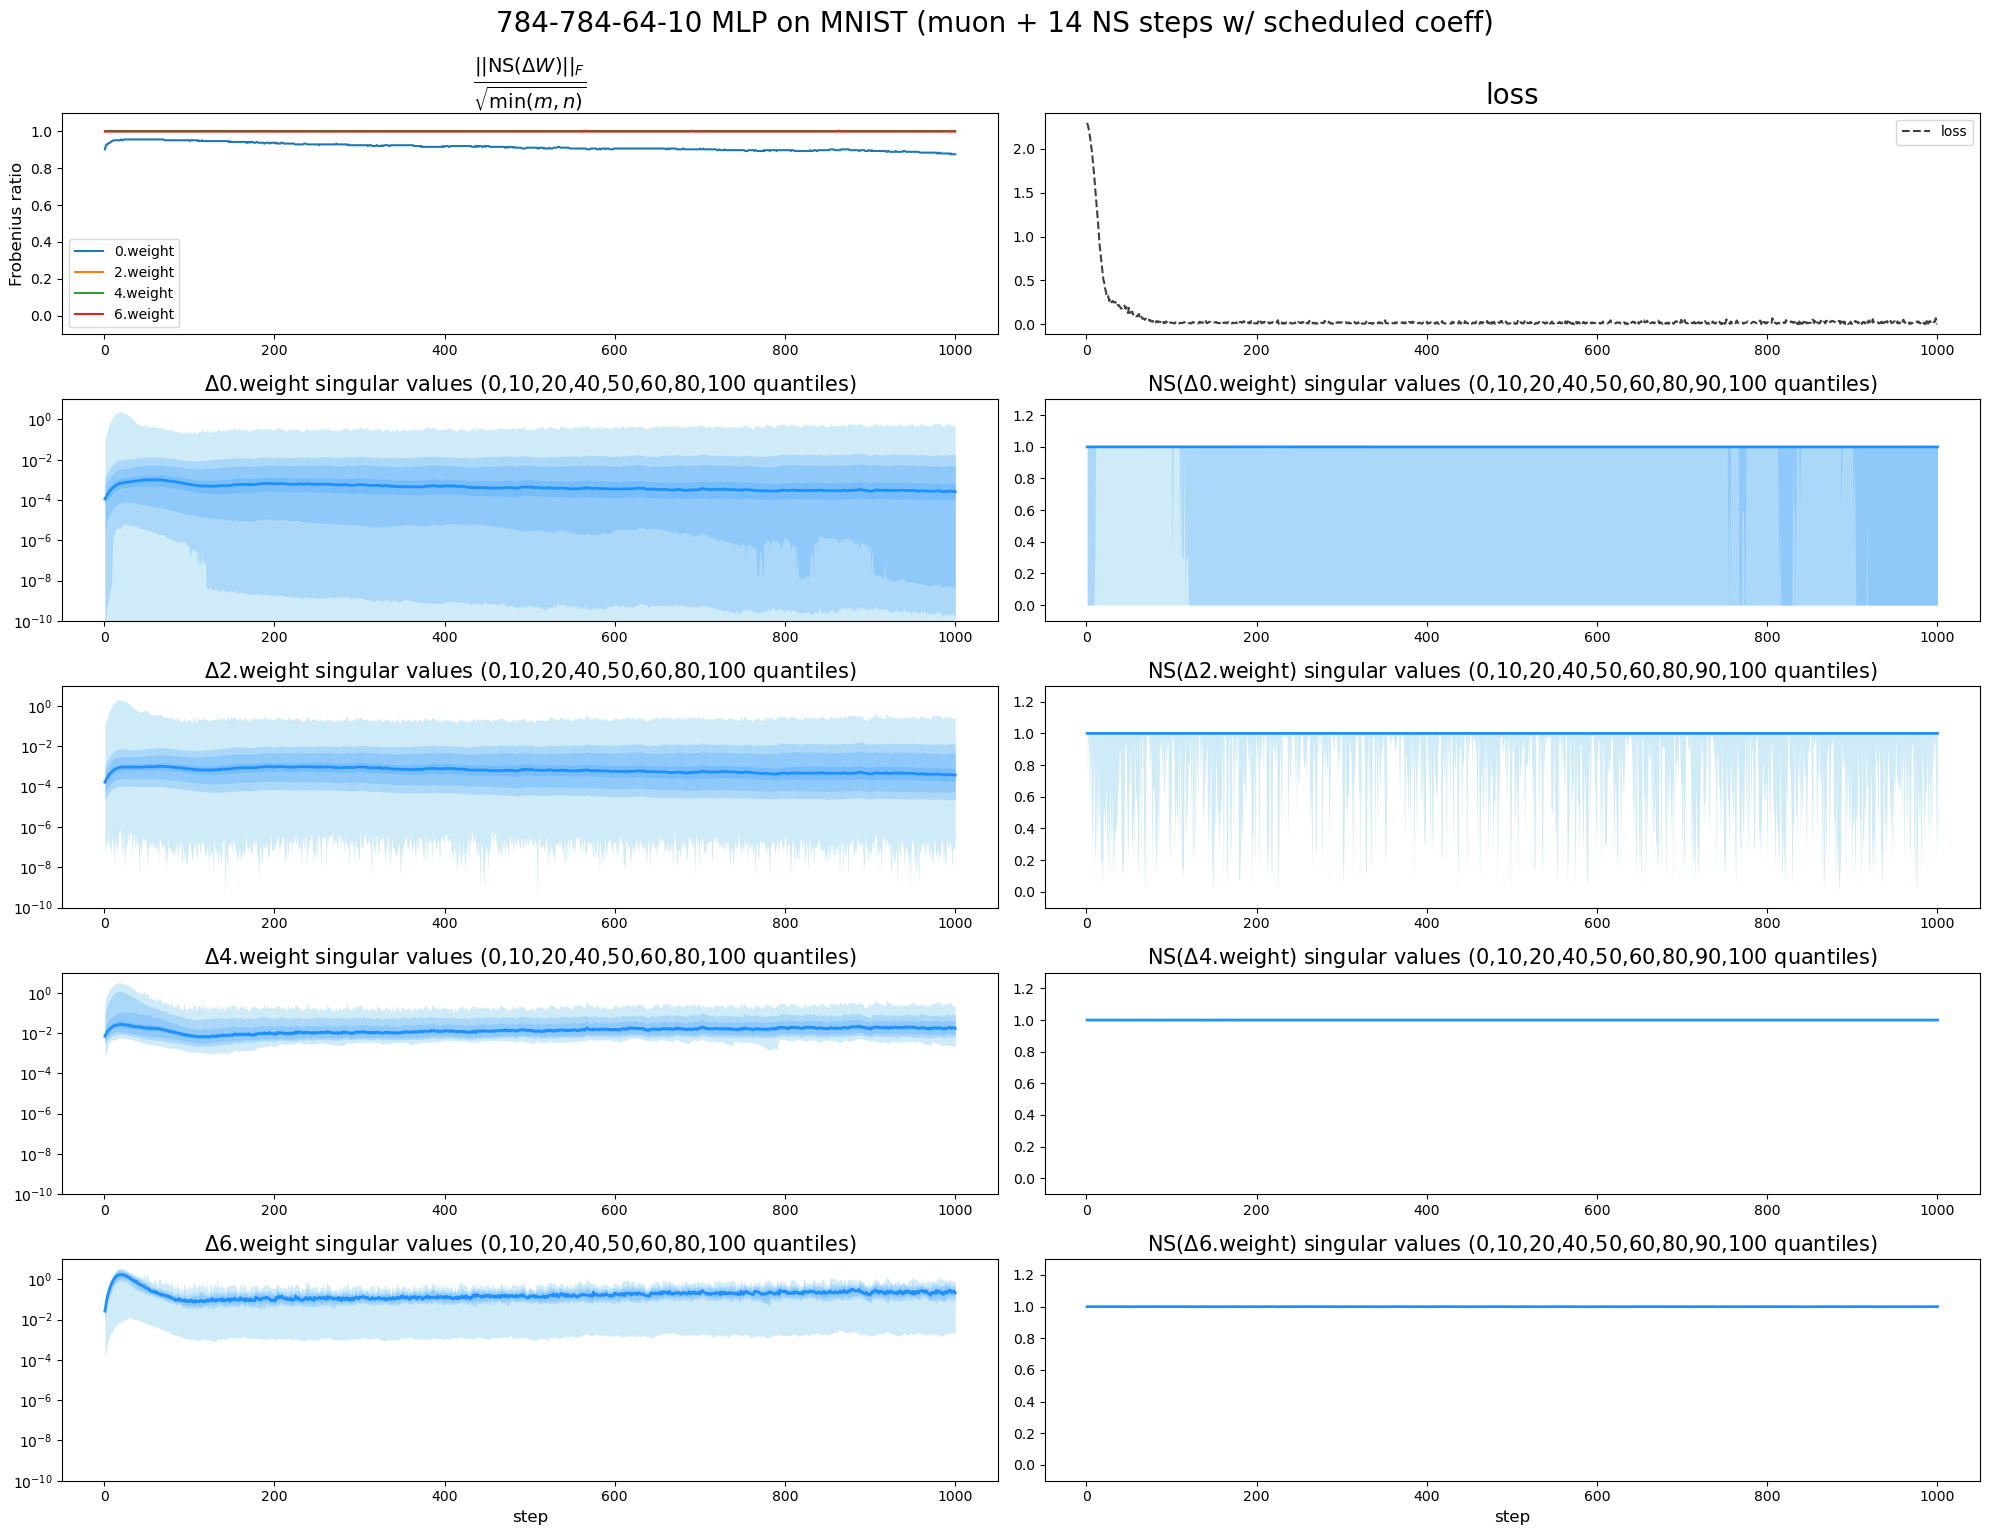

In [59]:
print(model)

fig, axs = plt.subplots(5, 2, figsize=(20, 15), dpi=100)

ax_fro = axs[0, 0]
ax_loss = axs[0, 1]

axs[-1, 0].set_xlabel('step', fontsize=12)
axs[-1, 1].set_xlabel('step', fontsize=12)

for k, param_traj in param_trajs.items():
    res = param_traj_res[k]
    fro_ratio = (
        res['rawg0norm_fro'] / min(param_traj.get_param(model).shape) **0.5
    )
    ax_fro.plot(res['steps'], fro_ratio, label=f'{k}')
ax_fro.legend()
ax_fro.set_ylabel(r'Frobenius ratio', fontsize=12)
ax_fro.legend()
ax_fro.set_title(r'$\frac{||\text{NS}(\Delta W)||_F}{\sqrt{\min(m, n)}}$', fontsize=20)
ax_fro.set_ylim([-0.1, 1.1])

ax_loss.plot(res['steps'], losses, c='k', ls='--', lw=1.5, alpha=0.75, label='loss')
ax_loss.set_title('loss', fontsize=20)
ax_loss.legend()

for param_key, (ax, ax0) in zip(param_keys, axs[1:, :]):
    res = param_traj_res[param_key]
    steps = res['steps']

    sv00, sv10, sv20, sv40, sv50, sv60, sv80, sv90, sv100 = res['rawgsv'].quantile(torch.tensor([0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1]), dim=-1).cpu().data.to(torch.float32)
    ax.fill_between(steps, sv00, sv100, color='skyblue', lw=0, alpha=0.4, label='0th-100th percentile')
    ax.fill_between(steps, sv10, sv90, color='dodgerblue', lw=0, alpha=0.2, label='10th-90th percentile')
    ax.fill_between(steps, sv20, sv80, color='dodgerblue', lw=0, alpha=0.2, label='20th-80th percentile')
    ax.fill_between(steps, sv40, sv60, color='dodgerblue', lw=0, alpha=0.2, label='40th-60th percentile')
    ax.plot(steps, sv50, lw=2, color='dodgerblue', label='median')
    ax.set_yscale('log')
    ax.set_ylim([1e-10, 1e1])
    ax.set_title(f'$\Delta${param_key} singular values (0,10,20,40,50,60,80,100 quantiles)', fontsize=15)

    sv00, sv10, sv20, sv40, sv50, sv60, sv80, sv90, sv100 = res['rawg0sv'].quantile(torch.tensor([0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1]), dim=-1).cpu().data.to(torch.float32)
    ax0.fill_between(steps, sv00, sv100, color='skyblue', lw=0, alpha=0.4, label='0th-100th percentile')
    ax0.fill_between(steps, sv10, sv90, color='dodgerblue', lw=0, alpha=0.2, label='10th-90th percentile')
    ax0.fill_between(steps, sv20, sv80, color='dodgerblue', lw=0, alpha=0.2, label='20th-80th percentile')
    ax0.fill_between(steps, sv40, sv60, color='dodgerblue', lw=0, alpha=0.2, label='40th-60th percentile')
    ax0.plot(steps, sv50, lw=2, color='dodgerblue', label='median')
    ax0.set_title(f'NS($\Delta${param_key}) singular values (0,10,20,40,50,60,80,90,100 quantiles)', fontsize=15)
    ax0.set_ylim([-0.1, 1.3])

plt.tight_layout()
fig.suptitle('784-784-64-10 MLP on MNIST (muon + 14 NS steps w/ scheduled coeff)', fontsize=20, y=1.02)
plt.show()


In [29]:
param_trajs['0.weight']['rawg0norm_fro'] / min(model._orig_mod[0].weight.shape) **0.5

tensor([0.6071, 0.5670, 0.5379, 0.5134, 0.4955, 0.4777, 0.4643, 0.4554, 0.4464,
        0.4375, 0.4308, 0.4241, 0.4196, 0.4174, 0.4174, 0.4196, 0.4174, 0.4196,
        0.4196, 0.4219, 0.4263, 0.4308, 0.4330, 0.4397, 0.4464, 0.4531, 0.4621,
        0.4710, 0.4777, 0.4888, 0.5000, 0.5156, 0.5246, 0.5424, 0.5446, 0.5603,
        0.5714, 0.5848, 0.5982, 0.6071, 0.6116, 0.6205, 0.6205, 0.6250, 0.6384,
        0.6384, 0.6429, 0.6473, 0.6518, 0.6562, 0.6607, 0.6518, 0.6696, 0.6696,
        0.6652, 0.6741, 0.6696, 0.6741, 0.6696, 0.6786, 0.6741, 0.6741, 0.6786,
        0.6875, 0.6875, 0.6920, 0.6920, 0.6920, 0.6920, 0.6920, 0.7009, 0.7009,
        0.7009, 0.7009, 0.7009, 0.7054, 0.7098, 0.7098, 0.7098, 0.7098, 0.7054,
        0.7054, 0.7098, 0.7098, 0.7054, 0.7143, 0.7098, 0.7054, 0.7054, 0.7098,
        0.7098, 0.7098, 0.7054, 0.7098, 0.7143, 0.7098, 0.7054, 0.6964, 0.7009,
        0.7054, 0.6920, 0.7009, 0.6920, 0.6964, 0.7054, 0.6964, 0.7009, 0.7054,
        0.6964, 0.6920, 0.6920, 0.6920, 

In [12]:
muon_renorm.OPTIM_MAP['muon'][0]

functools.partial(<class '241018_muon_renorm.Muon'>, backend='newtonschulz5')

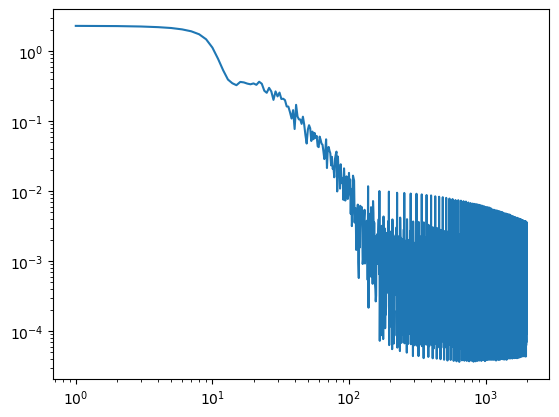

In [27]:
plt.plot(steps, losses)
plt.yscale('log')
plt.xscale('log')
plt.show()



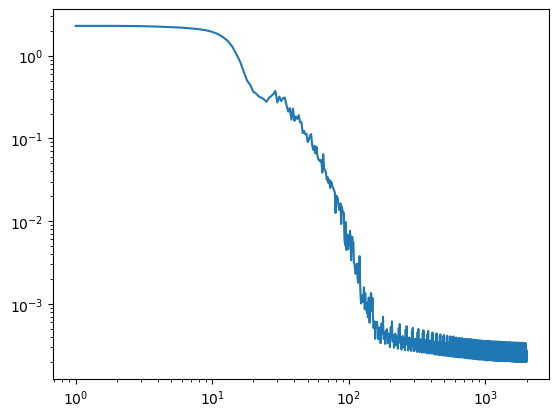

In [290]:
plt.plot(steps, losses)
plt.yscale('log')
plt.xscale('log')
plt.show()



In [21]:
!tail -n 100 {os.path.dirname(j['stdout_expanded']) + '/rank00.log'}


0: cpu-bind=MASK - isola-ada6000-1, task  0  0 [824351]: mask 0x7c000000000000007c0000000000000 set
0: Thu Oct 24 19:05:34 2024       
0: +-----------------------------------------------------------------------------------------+
0: | NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
0: |-----------------------------------------+------------------------+----------------------+
0: | GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
0: | Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
0: |                                         |                        |               MIG M. |
0: |=========================================+========================+======================|
0: |   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:02:00.0 Off |                  Off |
0: |  0%   32C    P8             28W /  280W |       2MiB /  49140MiB |      0%      Default |
0: |      

In [23]:
import json, subprocess
import datetime, time
from IPython.display import display
from time import sleep

# print('Test 1')
# sleep(1)
# dh.update('Test3')

uuid = '5be55e'


class printed_str(str):
    def __repr__(self):
       return self

dh = display('slurm status',display_id=True)
while True:
    # print human readable time
    time_str = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # dh.update(printed_str(time_str))
    out = json.loads(subprocess.getoutput('sacct --json -S 10/24-19:20'))
    jobs = {j['job_id']: j for j in out['jobs']}
    jobs = {k: j for k, j in jobs.items() if j['name'].endswith('-' + uuid)}

    pending = running = failed = successful = 0
    for _, j in jobs.items():
        state = j['state']['current'][0]
        if state == 'PENDING':
            pending += 1
        elif state == 'RUNNING':
            running += 1
        elif state == 'FAILED':
            failed += 1
        elif state == 'COMPLETED':
            if j['exit_code']['status'][0] == 'SUCCESS':
                successful += 1
            else:
                failed += 1
        else:
            raise ValueError(f'Unknown state: {j["state"]}')
    dh.update(printed_str(f'''{time_str}
Pending: {pending}, Running: {running}, Failed: {failed}, Successful: {successful}
'''))
    if running + pending == 0:
        break
    time.sleep(2)
    # now delete last two lines of output



2024-10-25 00:25:04
Pending: 0, Running: 0, Failed: 0, Successful: 435

In [18]:
import glob

files = sorted(glob.glob('241018_300steps_bzs2048/orth*_norm_jb_*.pth'))
# print(len(files))
for file in files:
    os.rename(file, file.replace('_norm_jb_', '_norm_jbinv_'))


In [17]:
import json, subprocess
import datetime, time
from IPython.display import display
from time import sleep

# print('Test 1')
# sleep(1)
# dh.update('Test3')

uuid = '5be55e'


class printed_str(str):
    def __repr__(self):
       return self

dh = display('slurm status',display_id=True)
while True:
    # print human readable time
    time_str = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # dh.update(printed_str(time_str))
    out = json.loads(subprocess.getoutput('sacct --json -S 10/24-19:20'))
    jobs = {j['job_id']: j for j in out['jobs']}
    jobs = {k: j for k, j in jobs.items() if j['name'].endswith('-' + uuid)}

    pending = running = failed = successful = 0
    for _, j in jobs.items():
        state = j['state']['current'][0]
        if state == 'PENDING':
            pending += 1
        elif state == 'RUNNING':
            running += 1
        elif state == 'FAILED':
            failed += 1
        elif state == 'COMPLETED':
            if j['exit_code']['status'][0] == 'SUCCESS':
                successful += 1
            else:
                failed += 1
        else:
            raise ValueError(f'Unknown state: {j["state"]}')
    dh.update(printed_str(f'''{time_str}
Pending: {pending}, Running: {running}, Failed: {failed}, Successful: {successful}
'''))
    if running + pending == 0:
        break
    time.sleep(2)
    # now delete last two lines of output



'241018_300steps_bzs2048/orth_muon_norm_jb_target_ema_grad_norm2_sqrt_lr0.0008_seed0.pth'

In [62]:
muon_renorm.should_rerun('muon_norm_spec_target_glbavgmomentum')

False

In [63]:
# reload_module()

lr_sm = [1e-7, 3e-7, 5e-7, 8e-7, 1e-6, 3e-6, 5e-6, 8e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]
lr_lg = [1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 3e-1, 5e-1, 8e-1, 1]
lrs = lr_sm + lr_lg

optims = sorted(OPTIM_MAP.keys())

print('''#!/bin/bash

set +e

START_TIME=$(date +"%m/%d/%y-%H:%M")
UUID6=$(echo -n $(date +%s%N) | md5sum | fold -w6 | shuf | head -n1)
''')

seed = 0
for lr in lrs:
    for optim_kind in optims:
        # if 'sign' not in optim:--
        #     continue
        file = f'241018_300steps_bzs2048/orth_{optim_kind}_lr{lr:g}_seed{seed}.pth'
        if not muon_renorm.should_rerun(optim_kind):
            continue
        # if os.path.exists(file):
        #     continue
        print(f"python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb nvidia_rtx_6000_ada_generation -uuid $UUID6 -q -e py312 {optim_kind}_{lr:g} -- python -u 241018_muon_renorm.py {optim_kind} {lr:g} 0")
        # if os.path.exists(file + '.running'):
        #     with open(file + '.running', 'r') as f:
        #         line = f.readline().strip()
        #         if line != '0':
        #             raise ValueError(f'{file} is not done')
        #     continue

print('echo "START_TIME=$START_TIME"')
print('echo "UUID=$UUID6"')
print('')


start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting start_preconditioning_step equal to precondition frequency 1 by default.
start_preconditioning_step set to -1. Setting st

#!/bin/bash

set +e

START_TIME=$(date +"%m/%d/%y-%H:%M")
UUID6=$(echo -n $(date +%s%N) | md5sum | fold -w6 | shuf | head -n1)

python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb nvidia_rtx_6000_ada_generation -uuid $UUID6 -q -e py312 adam_1e-07 -- python -u 241018_muon_renorm.py adam 1e-07 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb nvidia_rtx_6000_ada_generation -uuid $UUID6 -q -e py312 adam_b09_1e-07 -- python -u 241018_muon_renorm.py adam_b09 1e-07 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb nvidia_rtx_6000_ada_generation -uuid $UUID6 -q -e py312 adam_b095_1e-07 -- python -u 241018_muon_renorm.py adam_b095 1e-07 0
python /data/vision/phillipi/contrasti

In [110]:
model.load_state_dict(broken_sd)
data, target = data_target
with torch.no_grad():
    output = model(data.flatten(1))
    loss = F.cross_entropy(output, target)
print(f'Loss: {loss.item():.4f}')


Loss: 0.3066


In [111]:
# make model functional function of input and state dict
def func_call(param, input):
    return torch.func.functional_call(model, param, input)

bfunc_call = torch.vmap(func_call, in_dims=(-1, None), out_dims=(0,))


In [112]:
ws = torch.linspace(-1.5, 1.5, 500).to(torch.bfloat16).cuda()
interp_sd = {
    k: torch.lerp(pre_broken_sd[k][..., None], broken_sd[k][..., None], ws) for k in pre_broken_sd.keys()
}


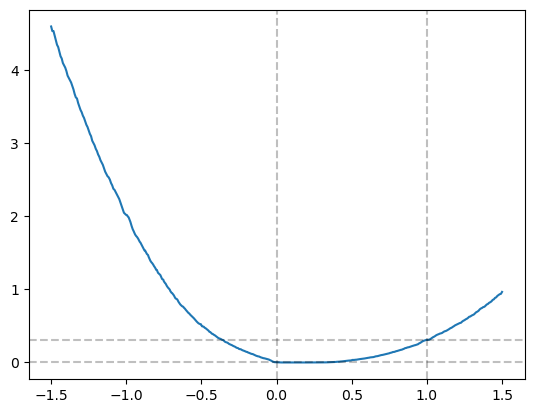

In [115]:
interp_losses = F.cross_entropy(bfunc_call(interp_sd, data.flatten(1)).flatten(0, 1), target.expand(ws.shape[0], -1).flatten(0, 1), reduction='none').unflatten(0, (ws.shape[0], -1)).mean(-1).cpu().data.to(torch.float32)

plt.plot(
    ws.cpu().data.to(torch.float32),
    interp_losses,
)
plt.axvline(0, c='k', ls='--', alpha=0.25)
plt.axhline(loss.item(), c='k', ls='--', alpha=0.25)
plt.axhline(0, c='k', ls='--', alpha=0.25)
plt.axvline(1, c='k', ls='--', alpha=0.25)
plt.show()


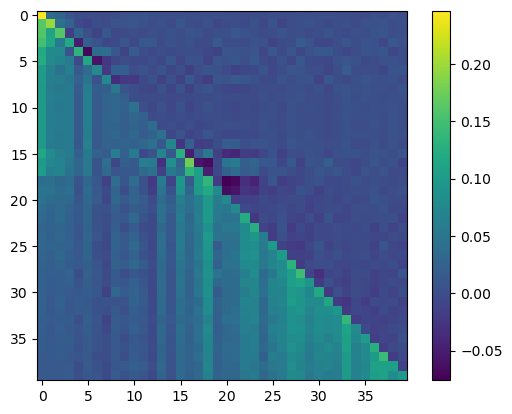

In [19]:
plt.imshow(F.cosine_similarity(updates[0:40].flatten(-2, -1)[:, None, :], grads[0:40].flatten(-2, -1)[None, :, :], dim=-1).cpu().data, interpolation='nearest')
plt.colorbar()
plt.show()



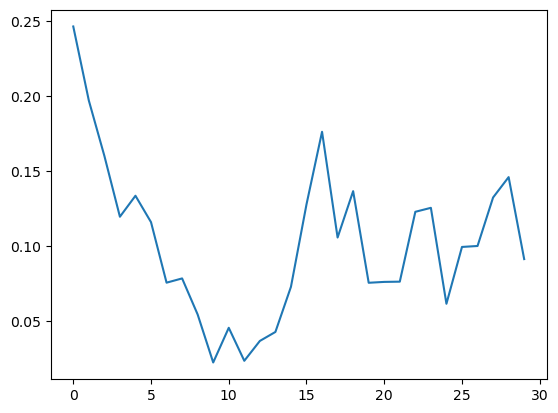

In [23]:
plt.plot(F.cosine_similarity(updates[:30].flatten(-2, -1), grads[:30].flatten(-2, -1), dim=-1).cpu().data)
plt.show()





In [138]:
import glob

for file in sorted(glob.glob('241018_300steps_bzs2048/orth*.running')):
    print(file)
    # os.rename(file, file.replace('muon_norm_fro_target', 'muon_norm_fro_exact_target'))

: 

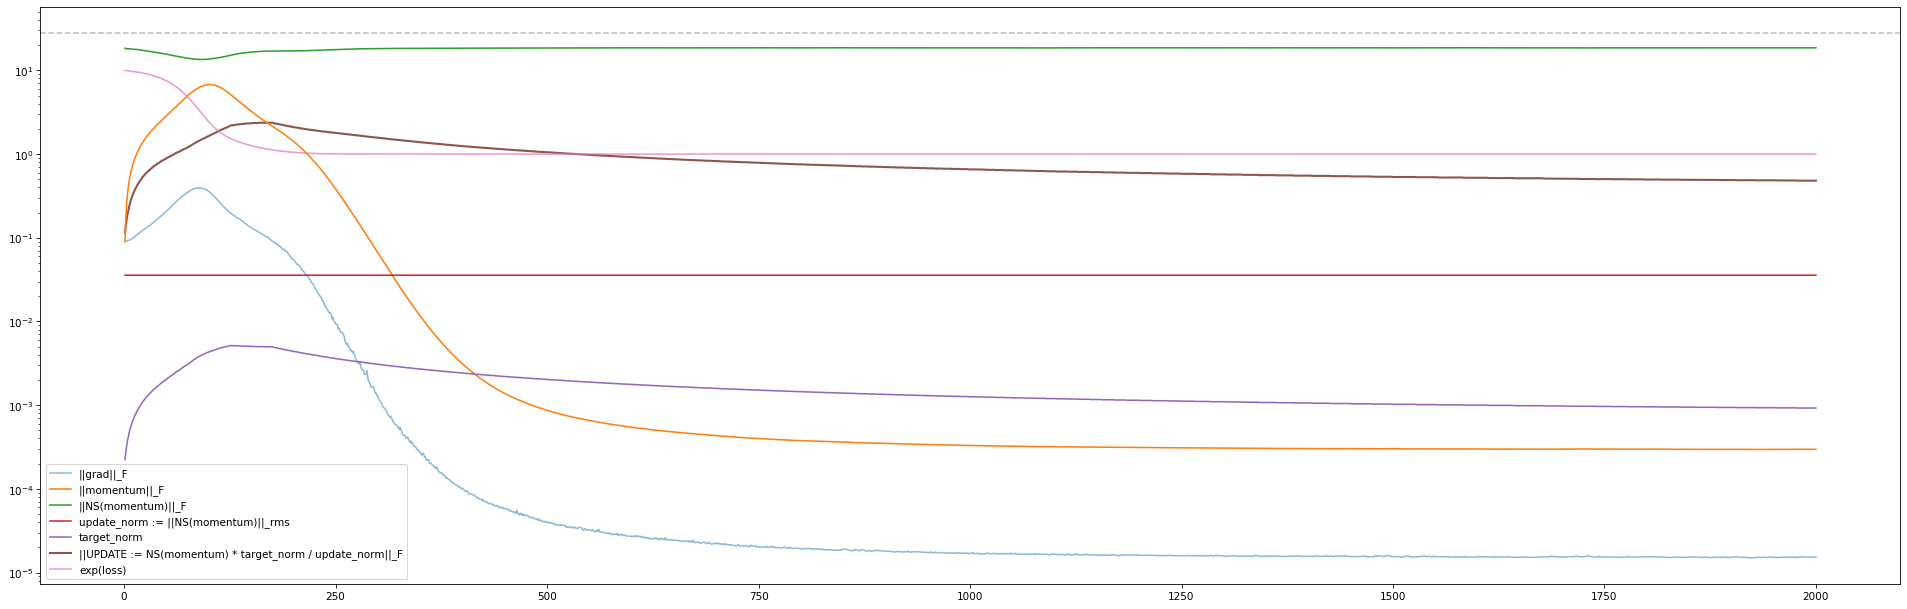

In [133]:
f, ax = plt.subplots(figsize=(32, 10), dpi=75)
plt.plot(steps, (grads.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||grad||_F', alpha=0.5)
plt.plot(steps, (momentums.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||momentum||_F', zorder=100)
plt.plot(steps, (updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||NS(momentum)||_F')
plt.plot(steps, (gnorms).cpu().data, label='update_norm := ||NS(momentum)||_rms', zorder=100)
plt.plot(steps, (target_norms).cpu().data, label='target_norm', zorder=100)
plt.plot(steps, (target_norms / gnorms * updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||UPDATE := NS(momentum) * target_norm / update_norm||_F', lw=2)
# plt.plot(steps, (momentum_0thpowers.flatten(-2, -1).norm(dim=-1)).cpu().data, label='momentum_0thpower norm')
plt.axhline(min(grads.shape[-2:]) ** 0.5, c='k', ls='--', alpha=0.25, zorder=100)
plt.plot(steps, torch.as_tensor(losses).exp().cpu().data, label='exp(loss)', alpha=0.75)
plt.yscale('log')
# plt.xscale('log')
# cap ylim to be no smaller than 1e-6 and no larger than 1e12
ymin, ymax = plt.ylim()
plt.ylim(max(ymin, 1e-12), min(ymax, 1e6))
# plt.xlim(0, 30)
plt.legend()
plt.show()